# Task description

The general task is to create a system that will recommend similar articles based on the previously
visited articles.

Input - Collection of articles (links or titles)

Output - Collection of recommended articles (links or titles) with a "score"

You will receive a grade for each of the following steps. The highest possible score withoutfinishing all parts is 4.0. For example, if you do perfectly the first two steps your grades will be 4.0, 4.0, 2.0.

Crawling and scraping - Download text from at least 1000 Wikipedia/fandom wiki articles. (Scrappy is not a must)

Stemming, lemmatization - preprocess downloaded documents into the most suitable form for this task. Store it as a .csv/parquet file or into a database.

Similarities - for a given collection of previously visited articles find the best matches in your database and recommend them to the user

GUI not required, notebook or any other reasonable form will be accepted. I have to be able to
provide a list of articles in an easy way and receive a meaningful recommendation.
You have to send the source code and report.
Report:
- pdf or notebook
- explain each step of your algorithm, especially how you score articles
- present interesting statistics about your database (most frequent words, histograms, similarities
between documents, ...)
- show some examples of recommendations with explanations (I'd prefer graphical form - see
prediction breakdowns for example)

Here are all the imports that we've used:

In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import random
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from nltk.tokenize import word_tokenize, wordpunct_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

from wordcloud import WordCloud, STOPWORDS
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Crawling and scraping

First part of the project - Crawling and Scraping. 

Here we built our own function scrape_article which connects to a given url and returns a title of the article, its text in the form of a string and a list of urls which it links to.

The other function is crawling - the name's pretty self-explanatory, starting from one article it visits all it's neighbours and it's neighbours neighbours until it meets the given threshold (or runs out of links to visit) It returns an array of texts and titles to be processed later.

In [ ]:
def scrape_article(url):
    html_response = None

    #Connects to website
    try:
        html = requests.get(url)
        html.raise_for_status()
    except:
        print('There has been an error connecting to the given url: ', url)
    else:
        #print('URL Connected')
        html_response = html.text

    #Using Beautiful Soup
    soup = BeautifulSoup(html_response, 'html.parser')
    
    #Gets title
    title = soup.find('h1', {'id': 'firstHeading'})
    title = title.get_text().strip()

    #Gets body content
    body_content = soup.find('div', {'id': 'content'})

    #Gets all links in body
    links = []
    for link in body_content.find_all('a', href=True):
        if(bool(re.search('(\/wiki\/).*', link['href'])) and not(':' in link['href'])):
            links.append('https://howtotrainyourdragon.fandom.com/' + link['href'])

    #Gets article tags
    tagsToExtract = ['h2', 'h3', 'p', 'ul', 'ol']
    mwContent = body_content.find('div', {'class': 'mw-parser-output'})
    supTags = mwContent.find_all('sup')
    for supTag in supTags:
        supTag.decompose()
    article_tags = mwContent.find_all(lambda tag: not tag.attrs, recursive=False)

    #Gets article text from tags
    headings = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']
    texts_list = []
    for tag in article_tags:
        if tag.name in headings:
            continue
        else:
            texts_list.append(tag.text)
    text = "\n".join(texts_list)
    return title, text, links

def crawl(url_start, epochs):
    #We want to crawl from the given url to 1000 more sites, so we have sets of visited and to_visit links, 
    #and iterate through found links till we get to 1000 or there are no more links to visit
    visited_links = set()
    links_to_visit = set()
    links_to_visit.add(url_start)
    texts = []
    titles = []
    articles_scraped = dict()
    while len(visited_links) < epochs or len(links_to_visit) == 0:
        url_to_visit = random.choice(tuple(links_to_visit))
        if url_to_visit not in visited_links:
            visited_links.add(url_to_visit)
            links_to_visit.remove(url_to_visit)
            title, text, links = scrape_article(url_to_visit)
            links_to_visit.update(links)
            texts.append(text)
            titles.append(title)
        else:
            links_to_visit.remove(url_to_visit)
        if len(visited_links) % 100 == 0:
            print(len(visited_links))
    return texts, titles

url = 'https://howtotrainyourdragon.fandom.com/wiki/Toothless_(Franchise)'
#writing out things to a file, because it got tiring to keep running it whenever we refreshed the collab session (it takes some time)
texts, titles = crawl(url, 1000)

100
200
200
300
400
500
600
700
800
900
1000


In [ ]:
print(titles[0])
print(texts[0])

Toothless


Toothless





							Third film
							
						



							Second film
							
						



							First film
							
						


























 Vital Statistics

Alias(es):
The Night FuryThe Last Known Night FuryThe Unholy Offspring of Lightning and Death ItselfThe Dragon Alpha (Astrid)Bud / Buddy (Hiccup)Useless Reptile (Hiccup)Big Baby-boo (Hiccup)Devil (Stoick)Hiccup's Other HalfMr. Night FuryDeathkiller (Dagur)Crazy Night Fury (Snotlout)T(Tuffnut, Ruffnut nd Dagur)The Idea Dragon (Snotlout)Johnny-complaints (Hiccup)The Mighty Toothless (Johann)Alpha of All Dragons (Hiccup)King of Dragons


Titles:
King of the Hidden World


Gender:
Male


Age:
15 (first film, the first three specials, ROB, DOB)18-19 (DOTDR, RTTE)20 (second film)21 (third film)30 (third film epilogue, Homecoming)


Height:
26 feet (7.92 meters) length


Eye Color:
Green


Rider:
Hiccup Horrendous Haddock IIIStoick the Vast (briefly)Snotlout Jorgenson (briefly)Fishlegs Ingerman (briefly)Dagur the Dera

# Stemming, lemmatization

Removing all words which are not wordlike (we accept only strings containing latin letters)

In [ ]:
texts  = [re.sub('\s+', ' ', text) for text in texts]
texts  = [re.sub('[^a-zA-Z \-]+', '', text) for text in texts]
print(texts[0])

 Toothless Third film Second film First film Vital Statistics Aliases The Night FuryThe Last Known Night FuryThe Unholy Offspring of Lightning and Death ItselfThe Dragon Alpha AstridBud  Buddy HiccupUseless Reptile HiccupBig Baby-boo HiccupDevil StoickHiccups Other HalfMr Night FuryDeathkiller DagurCrazy Night Fury SnotloutTTuffnut Ruffnut nd DagurThe Idea Dragon SnotloutJohnny-complaints HiccupThe Mighty Toothless JohannAlpha of All Dragons HiccupKing of Dragons Titles King of the Hidden World Gender Male Age  first film the first three specials ROB DOB- DOTDR RTTE second film third film third film epilogue Homecoming Height  feet  meters length Eye Color Green Rider Hiccup Horrendous Haddock IIIStoick the Vast brieflySnotlout Jorgenson brieflyFishlegs Ingerman brieflyDagur the Deranged brieflyTuffnut Thorston brieflyRuffnut Thorston brieflyAstrid Hofferson brieflyDrago Bludvist briefly Trainer Hiccup Horrendous Haddock III Race Night Fury FriendsAllies Hiccup Horrendous Haddock IIIAs

In [ ]:
texts  = [re.sub(r'([a-z])([A-Z])', r'\1 \2', text) for text in texts]
print(texts[0])

 Toothless Third film Second film First film Vital Statistics Aliases The Night Fury The Last Known Night Fury The Unholy Offspring of Lightning and Death Itself The Dragon Alpha Astrid Bud  Buddy Hiccup Useless Reptile Hiccup Big Baby-boo Hiccup Devil Stoick Hiccups Other Half Mr Night Fury Deathkiller Dagur Crazy Night Fury Snotlout TTuffnut Ruffnut nd Dagur The Idea Dragon Snotlout Johnny-complaints Hiccup The Mighty Toothless Johann Alpha of All Dragons Hiccup King of Dragons Titles King of the Hidden World Gender Male Age  first film the first three specials ROB DOB- DOTDR RTTE second film third film third film epilogue Homecoming Height  feet  meters length Eye Color Green Rider Hiccup Horrendous Haddock IIIStoick the Vast briefly Snotlout Jorgenson briefly Fishlegs Ingerman briefly Dagur the Deranged briefly Tuffnut Thorston briefly Ruffnut Thorston briefly Astrid Hofferson briefly Drago Bludvist briefly Trainer Hiccup Horrendous Haddock III Race Night Fury Friends Allies Hiccup

##Experiments:

Before building our pipeline we experimented a bit just to see how everything works - it did us justice, as we've found that the title "The Third" written in roman numerals was problematic and needed to provide a solution to that

In [ ]:
porter = PorterStemmer()
wordnet = WordNetLemmatizer()

In [ ]:
example_text = texts[0]
print(example_text)
example_text = porter.stem(example_text)
print(example_text)
example_tokenized = word_tokenize(example_text)
print(example_tokenized)
print(len(example_tokenized))
example_lematized = [wordnet.lemmatize(word) for word in example_tokenized]
print(example_lematized)
print(len(example_tokenized))

 Toothless Third film Second film First film Vital Statistics Aliases The Night Fury The Last Known Night Fury The Unholy Offspring of Lightning and Death Itself The Dragon Alpha Astrid Bud  Buddy Hiccup Useless Reptile Hiccup Big Baby-boo Hiccup Devil Stoick Hiccups Other Half Mr Night Fury Deathkiller Dagur Crazy Night Fury Snotlout TTuffnut Ruffnut nd Dagur The Idea Dragon Snotlout Johnny-complaints Hiccup The Mighty Toothless Johann Alpha of All Dragons Hiccup King of Dragons Titles King of the Hidden World Gender Male Age  first film the first three specials ROB DOB- DOTDR RTTE second film third film third film epilogue Homecoming Height  feet  meters length Eye Color Green Rider Hiccup Horrendous Haddock IIIStoick the Vast briefly Snotlout Jorgenson briefly Fishlegs Ingerman briefly Dagur the Deranged briefly Tuffnut Thorston briefly Ruffnut Thorston briefly Astrid Hofferson briefly Drago Bludvist briefly Trainer Hiccup Horrendous Haddock III Race Night Fury Friends Allies Hiccup

In [ ]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
example_lematized = [i for i in example_lematized if i not in stopwords.words('english')]
print(example_lematized)
print(len(example_lematized))

['toothless', 'third', 'film', 'second', 'film', 'first', 'film', 'vital', 'statistic', 'alias', 'night', 'fury', 'last', 'known', 'night', 'fury', 'unholy', 'offspring', 'lightning', 'death', 'dragon', 'alpha', 'astrid', 'bud', 'buddy', 'hiccup', 'useless', 'reptile', 'hiccup', 'big', 'baby-boo', 'hiccup', 'devil', 'stoick', 'hiccup', 'half', 'mr', 'night', 'fury', 'deathkiller', 'dagur', 'crazy', 'night', 'fury', 'snotlout', 'ttuffnut', 'ruffnut', 'nd', 'dagur', 'idea', 'dragon', 'snotlout', 'johnny-complaints', 'hiccup', 'mighty', 'toothless', 'johann', 'alpha', 'dragon', 'hiccup', 'king', 'dragon', 'title', 'king', 'hidden', 'world', 'gender', 'male', 'age', 'first', 'film', 'first', 'three', 'special', 'rob', 'dob-', 'dotdr', 'rtte', 'second', 'film', 'third', 'film', 'third', 'film', 'epilogue', 'homecoming', 'height', 'foot', 'meter', 'length', 'eye', 'color', 'green', 'rider', 'hiccup', 'horrendous', 'haddock', 'iiistoick', 'vast', 'briefly', 'snotlout', 'jorgenson', 'briefly',

In [ ]:
new_text = texts[0].replace('III', '')
new_text

' Toothless Third film Second film First film Vital Statistics Aliases The Night Fury The Last Known Night Fury The Unholy Offspring of Lightning and Death Itself The Dragon Alpha Astrid Bud  Buddy Hiccup Useless Reptile Hiccup Big Baby-boo Hiccup Devil Stoick Hiccups Other Half Mr Night Fury Deathkiller Dagur Crazy Night Fury Snotlout TTuffnut Ruffnut nd Dagur The Idea Dragon Snotlout Johnny-complaints Hiccup The Mighty Toothless Johann Alpha of All Dragons Hiccup King of Dragons Titles King of the Hidden World Gender Male Age  first film the first three specials ROB DOB- DOTDR RTTE second film third film third film epilogue Homecoming Height  feet  meters length Eye Color Green Rider Hiccup Horrendous Haddock Stoick the Vast briefly Snotlout Jorgenson briefly Fishlegs Ingerman briefly Dagur the Deranged briefly Tuffnut Thorston briefly Ruffnut Thorston briefly Astrid Hofferson briefly Drago Bludvist briefly Trainer Hiccup Horrendous Haddock  Race Night Fury Friends Allies Hiccup Horr

## Proper Tokenization, Stemming and Lemmatization:

After the experiment this is what we came up with for preprocessing our data:
1.   Replace all of the "III"
2.   Tokenize our text
3.   For each token lemmatize and porter stem it
4.   Clean the text to get rid of stopwords

In [ ]:
def tok_stem_lem(text):
    text = text.replace('III', '')
    tokenized = word_tokenize(text)
    token_lem_stem  = [porter.stem(wordnet.lemmatize(word)) for word in tokenized]
    clean_text = [word for word in token_lem_stem if word not in stopwords.words('english') and len(word) > 3]
    return " ".join(clean_text)
processed_texts = [tok_stem_lem(text) for text in texts]

## Visualisation

After that we decided that visualizations are in order, so we made them here:

In [ ]:
from collections import Counter
c = Counter()
for sublist in processed_texts:
  c.update(sublist.split())

In [ ]:
occurences = {k: v for k, v in sorted(c.items(), key=lambda item: item[1], reverse=True)}
occurences = list(occurences.items())

In [ ]:
top_occurences = np.transpose(np.array(occurences[:15]))
print(top_occurences)

[['dragon' 'hiccup' 'appear' 'toothless' 'berk' 'rider' 'astrid'
  'snotlout' 'also' 'fishleg' 'fire' 'first' 'island' 'like' 'stoick']
 ['12918' '6673' '3062' '2820' '2637' '2391' '2379' '2204' '2079' '2000'
  '1984' '1855' '1840' '1646' '1507']]


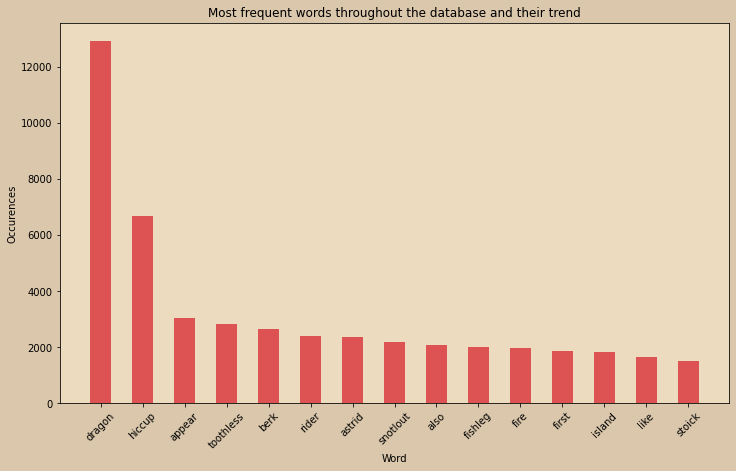

In [ ]:
fig = plt.figure(facecolor='#DBC8AC', figsize = (12, 7))
ax = plt.axes()
ax.set_facecolor('#EDDBC0')

plt.bar(top_occurences[0], top_occurences[1].astype(int), color = '#DD5353', width = 0.5)
plt.xticks(rotation = 45)
plt.xlabel('Word')
plt.ylabel('Occurences')
plt.title("Most frequent words throughout the database and their trend")
plt.show()

Here we found a pretty way to visualize our word frequency using a wordcloud:

In [ ]:
my_lst_str = ' '.join(map(str, processed_texts))

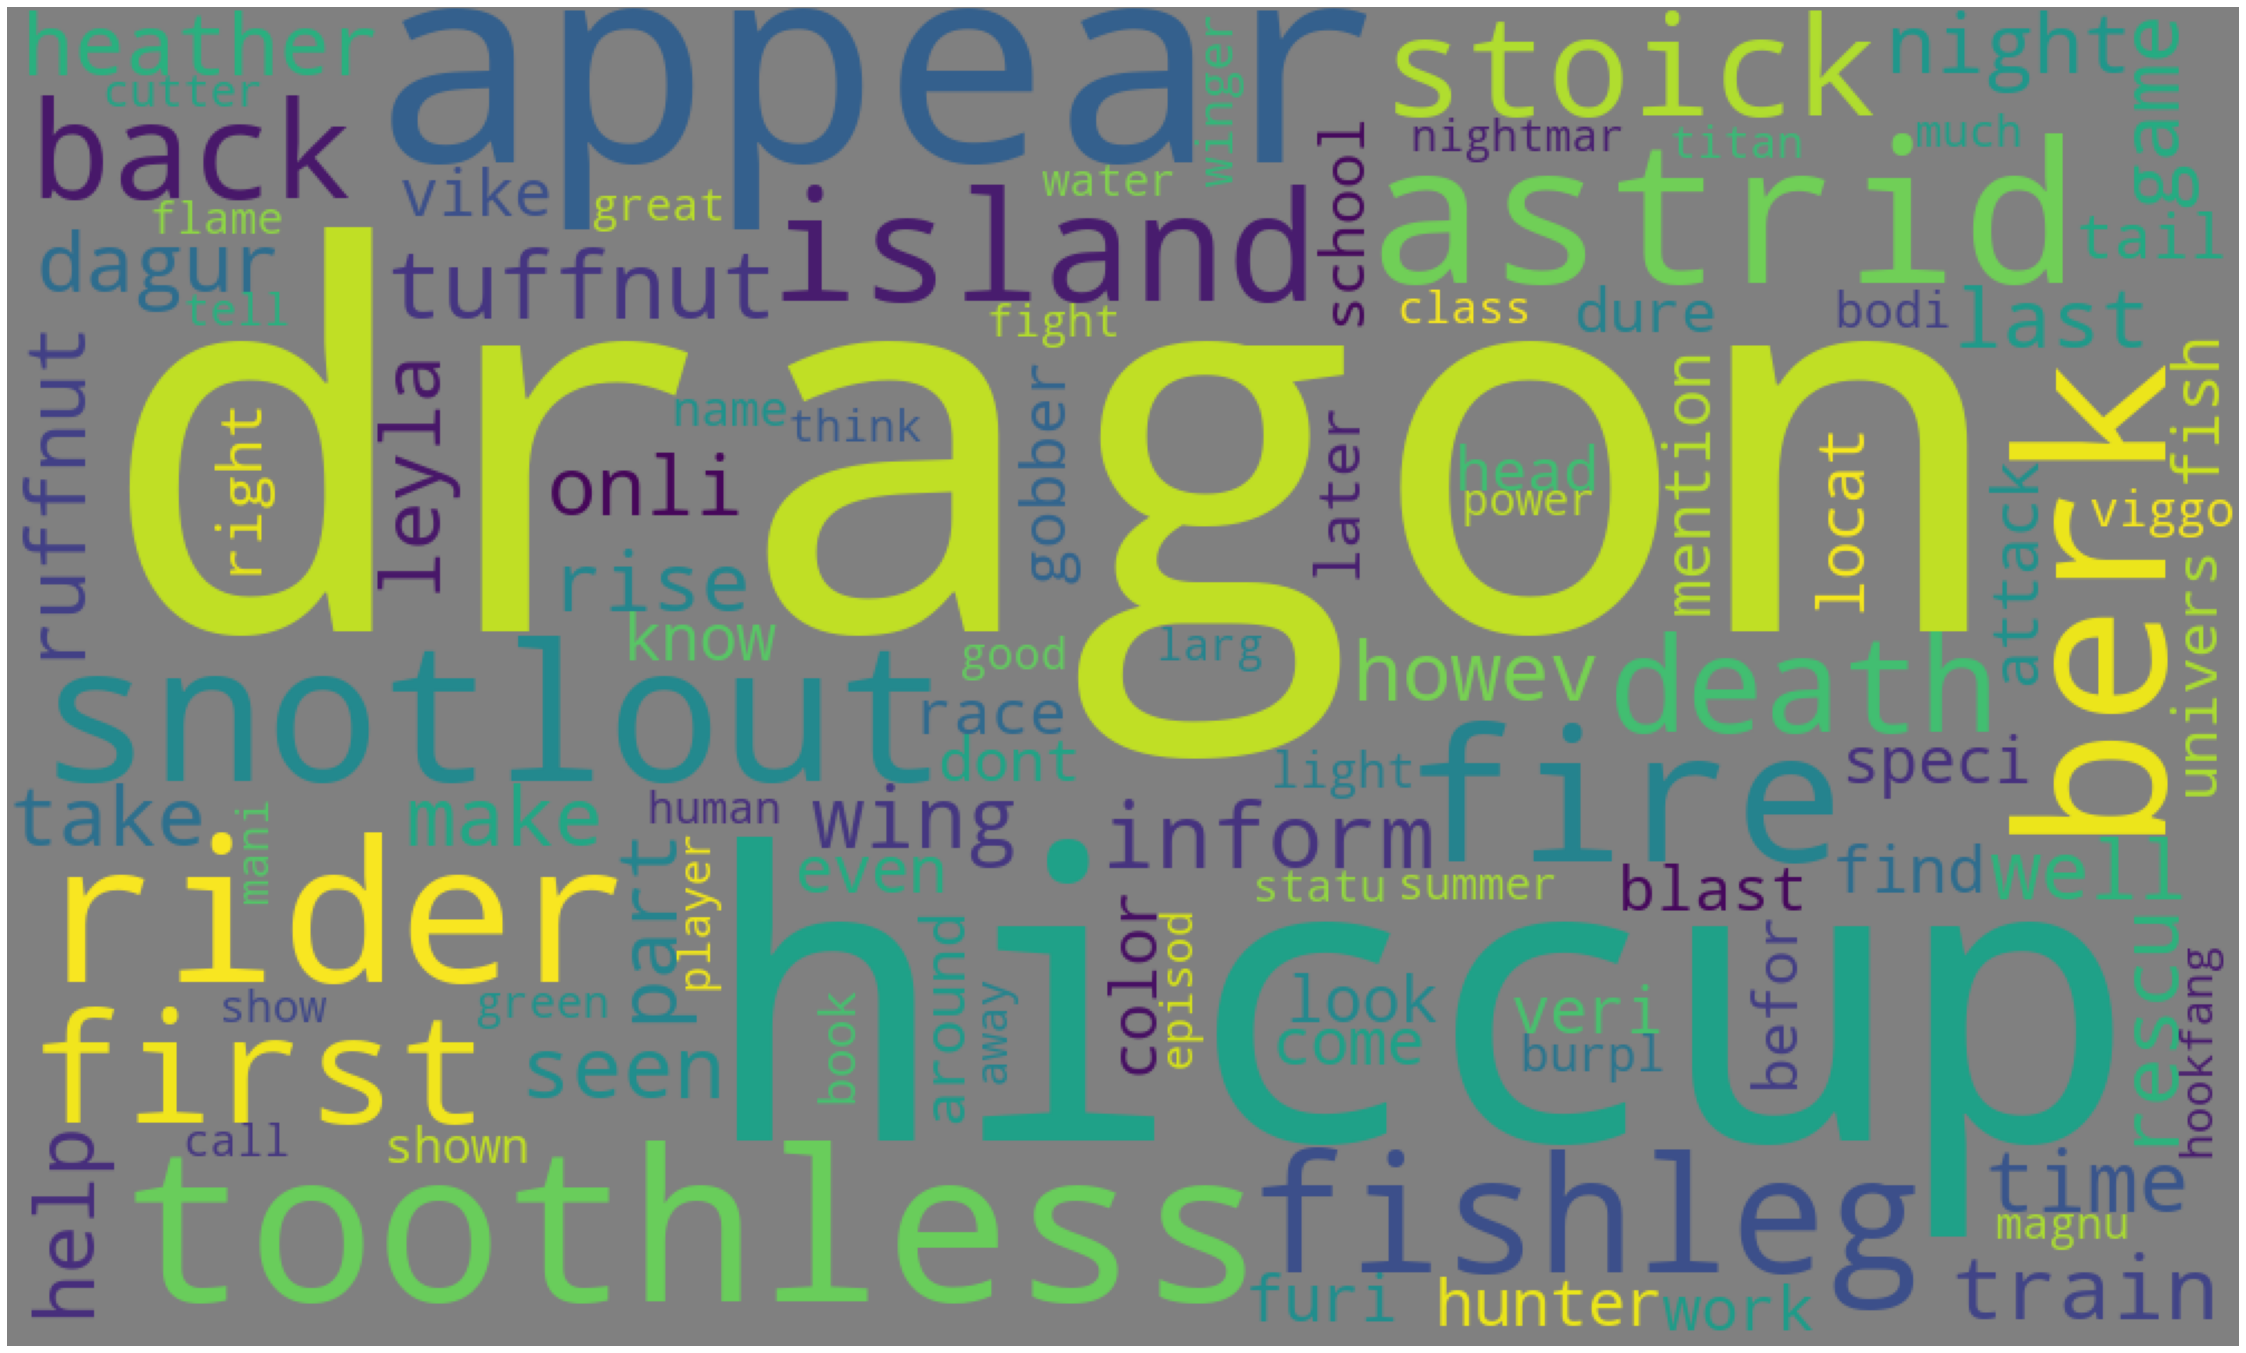

In [ ]:
wordcloud = WordCloud(width= 1000, height = 600, max_words=100,
                      random_state=1, background_color='gray', colormap='viridis_r',
                      collocations=False, stopwords = STOPWORDS).generate(my_lst_str)
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud) 
plt.axis("off")
plt.show()

Obviously on a how to train your dragon wiki the most frequent word is dragon. Next in line are the main characters of the series, which is not surprising

# Similarities

For similarities we used TfidfVectorizer from sklearn to build a matrix

In [ ]:
tfidf=TfidfVectorizer(use_idf=True, smooth_idf=False) 
tfidf_matrix = tfidf.fit_transform(processed_texts)
dfTFIDF = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix, index=titles, columns=tfidf.get_feature_names_out())

dfTFIDF

,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaahhhhhhhhh,aaaaaaaaaaah,aaaaaaah,aaaah,aaaarrrrrrrgggh,aaah,aaahhh,aardwolf,aaron,aaspindex,...,zipplewraith,zoehfeld,zoisit,zone,zoom,zoomerang,zoonot,zukor,zuri,zwyer
Toothless,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hunterbolt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Spring's Shadow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lethiferous Cromlech,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fissure Fault Ripper,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Prevarication Point,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Iron Isle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
How to Speak Dragonese,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Toby,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
pd.Series(tfidf.idf_, index=tfidf.get_feature_names_out()).sort_values()

dragon     1.036664
inform     1.102033
first      1.122168
appear     1.158996
last       1.251029
             ...   
lazili     7.907755
lawsuit    7.907755
lawson     7.907755
legum      7.907755
zwyer      7.907755
Length: 12404, dtype: float64

This is our searching function which based on the given history does pairwise cosine_similarity based on the above matrix of TFIDF and then adds the similarities to get a list of 5 titles recommended based on the history

In [ ]:
def search(history):
    indices = []
    cos_sim = []
    for each in history:
        index = titles.index(each)
        indices.append(index)
        cos_sim.append(cosine_similarity(tfidf_matrix[index:index+1], tfidf_matrix).flatten())
    for i in range(len(cos_sim)):
        cos_sim[i][indices] = 0
    cos_sim = np.array(cos_sim)
    results = np.sum(cos_sim.T, axis=1)
    return [titles[i] for i in results.argsort()[-5:][::-1]]

In [ ]:
history = random.sample(titles, 3)
history

['Mount Ymir', 'Nygren', 'Returnwing']

In [ ]:
reccomended = search(history)
reccomended

['Lars 2',
 'Skarsgard',
 'Dragon Hunters',
 'Snowmageddon',
 'Hiccup Horrendous Haddock III']